In [ ]:
%cd /ai-adulteration-detection

/content/drive/My Drive/Data Science Projects/Peynir/Peynir-Paper


In [ ]:
import numpy as np
import pandas as pd
import os
from os.path import isfile
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Bidirectional, LSTM, Dropout, Activation, GRU, TimeDistributed
from keras.layers import Conv2D, concatenate, MaxPooling2D, Flatten, Embedding, Lambda
from keras.layers import Conv1D, MaxPooling1D, Flatten, Conv2D, BatchNormalization, Lambda
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras.layers.advanced_activations import ELU
from keras import backend as K
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop
from keras import regularizers
import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### Raw waveform

In [ ]:
chunks_path = "/sliding_chunks"
filenames = sorted([f for f in os.listdir(chunks_path) if f.endswith('.wav')])
filename = filenames[13]

In [ ]:
filename

'Cheese_1009.wav'

In [ ]:
from scipy.io.wavfile import read
import scipy.signal as sps

# read and plot recordings by time
def plot_audio(filename):
    sample_rate, recording = read(os.path.join(chunks_path, filename))
    length = recording.shape[0]/sample_rate
    # print(f"Length of this file = {length} s")

    # Your new sampling rate
    new_rate = 200
    # Resample data
    number_of_samples = round(len(recording) * float(new_rate) / sample_rate)
    recording = sps.resample(recording, number_of_samples)

    time = np.linspace(0, length, recording.shape[0])
    plt.figure(figsize=(6, 4))
    plt.plot(time, recording)    
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.title("Raw waveform")
    plt.show()

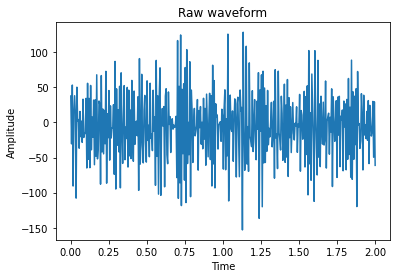

In [ ]:
plot_audio(filename)

### MFCC

In [ ]:
chunks_path = "/sliding_chunks"
filenames = sorted([f for f in os.listdir(chunks_path) if f.endswith('.wav')])

In [ ]:
filename = filenames[13]

In [ ]:
file_path = os.path.join(chunks_path, filename)
chunk, sample_rate = librosa.load(file_path, sr=None, res_type="kaiser_fast") 
mfccs = librosa.feature.mfcc(y=chunk, sr=sample_rate, n_mfcc=40)

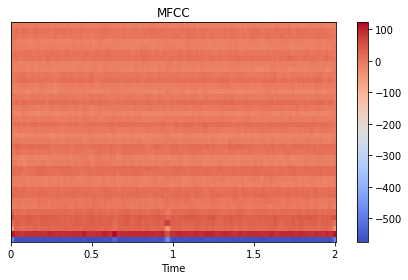

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
librosa.display.specshow(mfccs, x_axis="time", sr = sample_rate)
plt.colorbar()
plt.title("MFCC")
plt.tight_layout()

### Parallel CNN-RNN
- Cross-validation accuracy and loss 
- Confusion Matrices
  - For test set


#### Cross-validation accuracy and loss

In [ ]:
%cd /Parallel CNN-RNN/npz_files_results
train_accuracy = np.load("train_accuracy_arr_MFCCs.npz", allow_pickle = True)
train_accuracy_arr = train_accuracy['arr_0']
train_loss = np.load("train_loss_arr_MFCCs.npz", allow_pickle = True)
train_loss_arr = train_loss['arr_0']
valid_accuracy = np.load("valid_accuracy_arr_MFCCs.npz", allow_pickle = True)
valid_accuracy_arr = valid_accuracy['arr_0']
valid_loss = np.load("valid_loss_arr_MFCCs.npz", allow_pickle = True)
valid_loss_arr = valid_loss['arr_0']
%cd ..
EPOCH_COUNT = 25

In [ ]:
train_accuracy_mean = np.mean(train_accuracy_arr, axis = 0)
train_accuracy_std = np.std(train_accuracy_arr, axis = 0)
valid_accuracy_mean = np.mean(valid_accuracy_arr, axis = 0)
valid_accuracy_std = np.std(valid_accuracy_arr, axis = 0)

train_loss_mean = np.mean(train_loss_arr, axis = 0)
train_loss_std = np.std(train_loss_arr, axis = 0)
valid_loss_mean = np.mean(valid_loss_arr, axis = 0)
valid_loss_std = np.std(valid_loss_arr, axis = 0)

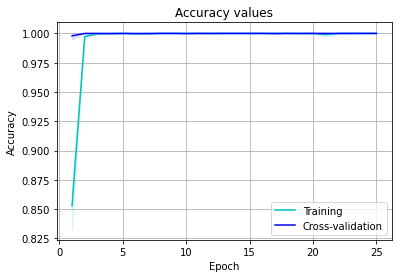

In [ ]:
# Plot accuracy curve
epochs = np.linspace(1, EPOCH_COUNT, EPOCH_COUNT)

plt.figure(figsize=(6,4))

plt.fill_between(epochs, train_accuracy_mean - train_accuracy_std,
                 train_accuracy_mean + train_accuracy_std, alpha = 0.1,
                 color = "c")
plt.fill_between(epochs, valid_accuracy_mean - valid_accuracy_std,
                 valid_accuracy_mean + valid_accuracy_std, alpha = 0.1,
                 color = "b")
   
plt.plot(epochs, train_accuracy_mean, color = "c",
         label = "Training")
plt.plot(epochs, valid_accuracy_mean, color = "b",
         label = "Cross-validation")

plt.title('Accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc = 'lower right')
plt.grid()
plt.show()

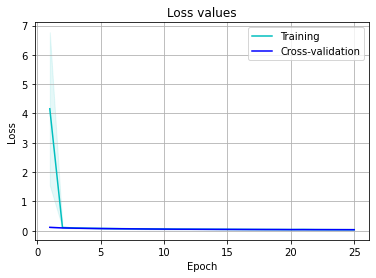

In [ ]:
# Plot loss curve
epochs = np.linspace(1, EPOCH_COUNT, EPOCH_COUNT)

plt.figure(figsize=(6,4))

plt.fill_between(epochs, train_loss_mean - train_loss_std,
                 train_loss_mean + train_loss_std, alpha = 0.1,
                 color = "c")
plt.fill_between(epochs, valid_loss_mean - valid_loss_std,
                 valid_loss_mean + valid_loss_std, alpha = 0.1,
                 color = "b")
   
plt.plot(epochs, train_loss_mean, color = "c",
         label = "Training")
plt.plot(epochs, valid_loss_mean, color = "b",
         label = "Cross-validation")

plt.title('Loss values')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc = 'upper right')
plt.grid()
plt.show()

#### Confusion Matrices

In [ ]:
train_data_path = "/npz_files/shuffled_train_arr_MFCCs.npz"
train_data = np.load(train_data_path, allow_pickle = True)
arr_0_train = train_data['arr_0']
arr_1_train = train_data['arr_1']
print(arr_0_train.shape, arr_1_train.shape)

valid_data_path = "/npz_files/shuffled_valid_arr_MFCCs.npz"
valid_data = np.load(valid_data_path, allow_pickle = True)
arr_0_valid = valid_data['arr_0']
arr_1_valid = valid_data['arr_1']
print(arr_0_valid.shape, arr_1_valid.shape)

X = np.concatenate((arr_0_train, arr_0_valid))
y = np.concatenate((arr_1_train, arr_1_valid))
print(X.shape, y.shape)

(8010, 173, 40) (8010,)
(1001, 173, 40) (1001,)
(9011, 173, 40) (9011,)


In [ ]:
def parallel_conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### Convolutional Blocks
    conv_1 = Conv2D(filters = nb_filters1, kernel_size = ksize, strides = 1,
                      padding = 'valid', activation = 'relu', name = 'conv_1')(layer)
    pool_1 = MaxPooling2D(pool_size_1)(conv_1)
    
    conv_2 = Conv2D(filters = nb_filters2, kernel_size = ksize, strides = 1,
                      padding = 'valid', activation = 'relu', name = 'conv_2')(pool_1)
    pool_2 = MaxPooling2D(pool_size_2)(conv_2)
    
    conv_3 = Conv2D(filters = nb_filters3, kernel_size = ksize, strides=1,
                      padding = 'valid', activation = 'relu', name = 'conv_3')(pool_2)
    pool_3 = MaxPooling2D(pool_size_3)(conv_3)
        
    flatten1 = Flatten()(pool_3)
    
    ### Recurrent Block
    
    # Pooling layer
    pool_lstm1 = MaxPooling2D(pool_size_4, name = 'pool_lstm')(layer)
    
    # Embedding layer
    squeezed = Lambda(lambda x: K.squeeze(x, axis = -1))(pool_lstm1)
    
    # Bidirectional GRU
    lstm = LSTM(LSTM_COUNT, return_sequences = False)(squeezed)
   
    ### Concat Output
    concat = concatenate([flatten1, lstm], axis = -1, name = 'concat')

    ### Dense Layer
    dense_layer = Dense(64, kernel_regularizer = regularizers.l2(0.001), name = 'dense1')(concat)
    drop_layer = Dropout(0.4)(dense_layer)
    
    ### Softmax Output
    output = Dense(num_classes, activation = 'softmax', name = 'preds')(drop_layer)
    
    model_output = output
    model = Model(model_input, model_output)
    
    opt = Adam(lr=0.001)
    model.compile(loss = 'categorical_crossentropy',
                  optimizer = opt,
                  metrics = ['accuracy'])
    
    # print(model.summary())
    return model

In [ ]:
def train_model(x, y):
    
    n_frequency = x.shape[2]
    n_frames = x.shape[1]

    x = np.expand_dims(x, axis = -1)
          
    input_shape = (n_frames, n_frequency, 1)
    model_input = Input(input_shape, name = 'input')
    
    model = parallel_conv_recurrent_model_build(model_input)
    
    model_filepath = "/models/Test_of_Parallel_CNN_RNN_MFCCs_withCV_model.h5"
    checkpoint_callback = ModelCheckpoint(filepath = model_filepath, monitor = 'accuracy', verbose = 1,
                                          save_best_only = True, mode = 'max')
    
    reducelr_callback = ReduceLROnPlateau(monitor = 'accuracy', factor = 0.5, patience = 10, min_delta = 0.01, verbose = 1)
    callbacks_list = [checkpoint_callback, reducelr_callback]

    # Fit the model and get training history
    print('Training...')
    history = model.fit(x, y, batch_size = BATCH_SIZE, epochs = EPOCH_COUNT,
                        verbose = 2, callbacks = callbacks_list)
    # verbose: 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.

    return model, history

For test set:

In [ ]:
# Compile the model
num_classes = np.amax(y) + 1 # y.shape[1]
n_features = X.shape[2]
n_time = X.shape[1]

nb_filters1 = 16 
nb_filters2 = 32 
nb_filters3 = 64
ksize = (3, 1)
pool_size_1 = (2, 2) 
pool_size_2 = (2, 2)
pool_size_3 = (2, 2)
pool_size_4 = (2, 1)
LSTM_COUNT = 96

BATCH_SIZE = 64
EPOCH_COUNT = 25

n_frequency = X.shape[2]
n_frames = X.shape[1]
    
input_shape = (n_frames, n_frequency, 1)
model_input = Input(input_shape, name = 'input')
    
model = parallel_conv_recurrent_model_build(model_input)

model.load_weights("/models/Test_of_Parallel_CNN_RNN_MFCCs_withCV_model.h5") 

Building model...


In [ ]:
test_data_path = "/npz_files/shuffled_test_arr_MFCCs.npz"
test_data = np.load(test_data_path, allow_pickle = True)
arr_0_test = test_data['arr_0']
arr_1_test = test_data['arr_1']

X_test = arr_0_test
print(X_test.shape) 
from keras.utils import to_categorical
y_test = to_categorical(arr_1_test)
print(y_test.shape)

(1002, 173, 40)
(1002, 4)


In [ ]:
X_test = np.expand_dims(X_test, axis = -1)

dict_classes = {"Cheese":0, "Empty":1, "NonorganicButter":2, "OrganicButter":3}

y_true = np.argmax(y_test, axis = 1)

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)

target_names = dict_classes.keys()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred, labels = [0, 1, 2, 3], target_names=target_names))
print(confusion_matrix(y_true, y_pred, labels = [0, 1, 2, 3]))

                  precision    recall  f1-score   support

          Cheese       1.00      1.00      1.00       268
           Empty       1.00      1.00      1.00       236
NonorganicButter       1.00      1.00      1.00       243
   OrganicButter       1.00      1.00      1.00       255

        accuracy                           1.00      1002
       macro avg       1.00      1.00      1.00      1002
    weighted avg       1.00      1.00      1.00      1002

[[268   0   0   0]
 [  0 236   0   0]
 [  0   0 243   0]
 [  0   0   0 255]]


In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred, labels = [0, 1, 2, 3])
cm_df = pd.DataFrame(cm,
                     index = ["Cheese", "Empty", "Non-Organic Butter", "Organic Butter"], 
                     columns = ["Cheese", "Empty", "Non-Organic Butter", "Organic Butter"])

plt.figure(figsize=(4,4))
sns.heatmap(cm_df, cmap="Blues", annot=True, fmt='d', linewidths=.5, linecolor='black', square = True)
plt.title('Confusion Matrix for Test Set \n(Parallel CNN-RNN & CRNN)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### CRNN
- Cross-validation accuracy and loss 
- Confusion Matrices
  - For test set


#### Cross-validation accuracy and loss

In [ ]:
%cd /CRNN/npz_files_results
train_accuracy = np.load("train_accuracy_arr_MFCCs.npz", allow_pickle = True)
train_accuracy_arr = train_accuracy['arr_0']
train_loss = np.load("train_loss_arr_MFCCs.npz", allow_pickle = True)
train_loss_arr = train_loss['arr_0']
valid_accuracy = np.load("valid_accuracy_arr_MFCCs.npz", allow_pickle = True)
valid_accuracy_arr = valid_accuracy['arr_0']
valid_loss = np.load("valid_loss_arr_MFCCs.npz", allow_pickle = True)
valid_loss_arr = valid_loss['arr_0']
%cd ..
EPOCH_COUNT = 50

In [ ]:
train_accuracy_mean = np.mean(train_accuracy_arr, axis = 0)
train_accuracy_std = np.std(train_accuracy_arr, axis = 0)
valid_accuracy_mean = np.mean(valid_accuracy_arr, axis = 0)
valid_accuracy_std = np.std(valid_accuracy_arr, axis = 0)

train_loss_mean = np.mean(train_loss_arr, axis = 0)
train_loss_std = np.std(train_loss_arr, axis = 0)
valid_loss_mean = np.mean(valid_loss_arr, axis = 0)
valid_loss_std = np.std(valid_loss_arr, axis = 0) 

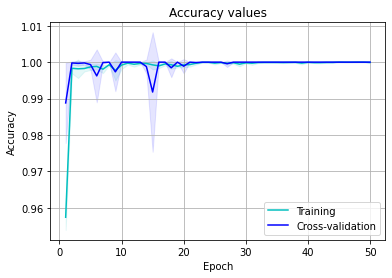

In [ ]:
# Plot accuracy curve
epochs = np.linspace(1, EPOCH_COUNT, EPOCH_COUNT)

plt.figure(figsize=(6,4))

plt.fill_between(epochs, train_accuracy_mean - train_accuracy_std,
                 train_accuracy_mean + train_accuracy_std, alpha = 0.1,
                 color = "c")
plt.fill_between(epochs, valid_accuracy_mean - valid_accuracy_std,
                 valid_accuracy_mean + valid_accuracy_std, alpha = 0.1,
                 color = "b")
   
plt.plot(epochs, train_accuracy_mean, color = "c",
         label = "Training")
plt.plot(epochs, valid_accuracy_mean, color = "b",
         label = "Cross-validation")

plt.title('Accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc = 'lower right')
plt.grid()
plt.show()

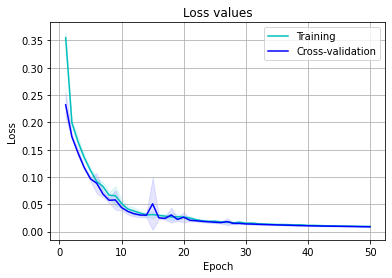

In [ ]:
# Plot loss curve
epochs = np.linspace(1, EPOCH_COUNT, EPOCH_COUNT)

plt.figure(figsize=(6,4))

plt.fill_between(epochs, train_loss_mean - train_loss_std,
                 train_loss_mean + train_loss_std, alpha = 0.1,
                 color = "c")
plt.fill_between(epochs, valid_loss_mean - valid_loss_std,
                 valid_loss_mean + valid_loss_std, alpha = 0.1,
                 color = "b")
   
plt.plot(epochs, train_loss_mean, color = "c",
         label = "Training")
plt.plot(epochs, valid_loss_mean, color = "b",
         label = "Cross-validation")

plt.title('Loss values')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid()
plt.show()

#### Confusion Matrices

In [ ]:
train_data_path = "/npz_files/shuffled_train_arr_MFCCs.npz"
train_data = np.load(train_data_path, allow_pickle = True)
arr_0_train = train_data['arr_0']
arr_1_train = train_data['arr_1']
print(arr_0_train.shape, arr_1_train.shape)

valid_data_path = "/npz_files/shuffled_valid_arr_MFCCs.npz"
valid_data = np.load(valid_data_path, allow_pickle = True)
arr_0_valid = valid_data['arr_0']
arr_1_valid = valid_data['arr_1']
print(arr_0_valid.shape, arr_1_valid.shape)

X = np.concatenate((arr_0_train, arr_0_valid))
y = np.concatenate((arr_1_train, arr_1_valid))
print(X.shape, y.shape) 

(8010, 173, 40) (8010,)
(1001, 173, 40) (1001,)
(9011, 173, 40) (9011,)


In [ ]:
def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### 3 1D Convolution Layers
    for i in range(N_LAYERS):
        
        layer = Conv1D(
                filters = CONV_FILTER_COUNT,
                kernel_size = FILTER_LENGTH,
                kernel_regularizer = regularizers.l2(L2_regularization),
                name='convolution_' + str(i + 1))(layer)
        layer = BatchNormalization(momentum = 0.9)(layer)
        layer = Activation('relu')(layer)
        layer = MaxPooling1D(2)(layer)
        layer = Dropout(0.4)(layer)

    ### LSTM Layer
    layer = LSTM(LSTM_COUNT, return_sequences = False)(layer)
    layer = Dropout(0.4)(layer)
    
    ### Dense Layer
    layer = Dense(NUM_HIDDEN, kernel_regularizer = regularizers.l2(L2_regularization), name = 'dense1')(layer)
    layer = Dropout(0.4)(layer)
    
    ### Softmax Output
    layer = Dense(num_classes)(layer)
    layer = Activation('softmax', name = 'output_realtime')(layer)
    model_output = layer
    model = Model(model_input, model_output)
    
    opt = Adam(lr=0.001)
    model.compile(loss = 'categorical_crossentropy',
                  optimizer = opt,
                  metrics = ['accuracy'])
    
    # print(model.summary())
    return model

In [ ]:
def train_model(x, y):
    
    n_features = x.shape[2]
    input_shape = (None, n_features)
    model_input = Input(input_shape, name = 'input')
    
    model = conv_recurrent_model_build(model_input)

    model_filepath = "/models/Test_of_CRNN_MFCCs_withCV_model.h5"
    checkpoint_callback = ModelCheckpoint(filepath = model_filepath, monitor = 'accuracy', verbose = 1,
                                          save_best_only = True, mode = 'max')
    
    reducelr_callback = ReduceLROnPlateau(monitor = 'accuracy', factor = 0.5, patience = 10, min_delta = 0.01, verbose = 1)
    callbacks_list = [checkpoint_callback, reducelr_callback]

    # Fit the model and get training history
    print('Training...')
    history = model.fit(x, y, batch_size = BATCH_SIZE, epochs = EPOCH_COUNT,
                        verbose = 2, callbacks = callbacks_list)
    # verbose: 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.

    return model, history

For test set:

In [ ]:
# Compile the model
num_classes = np.amax(y) + 1 # y.shape[1]
n_features = X.shape[2]
n_time = X.shape[1]

N_LAYERS = 3
FILTER_LENGTH = 5
CONV_FILTER_COUNT = 56
BATCH_SIZE = 64
LSTM_COUNT = 96
EPOCH_COUNT = 50
NUM_HIDDEN = 64
L2_regularization = 0.001

n_features = X.shape[2]
input_shape = (None, n_features)
model_input = Input(input_shape, name = 'input')

model = conv_recurrent_model_build(model_input)

model.load_weights("/models/Test_of_CRNN_MFCCs_withCV_model.h5")

Building model...


In [ ]:
test_data_path = "/npz_files/shuffled_test_arr_MFCCs.npz"
test_data = np.load(test_data_path, allow_pickle = True)
arr_0_test = test_data['arr_0']
arr_1_test = test_data['arr_1']

X_test = arr_0_test
print(X_test.shape) 
from keras.utils import to_categorical
y_test = to_categorical(arr_1_test, num_classes = 4)
print(y_test.shape)

(1002, 173, 40)
(1002, 4)


In [ ]:
dict_classes = {"Cheese":0, "Empty":1, "NonorganicButter":2, "OrganicButter":3}

y_true = np.argmax(y_test, axis = 1)

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)

target_names = dict_classes.keys()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred, labels = [0, 1, 2, 3], target_names=target_names))
print(confusion_matrix(y_true, y_pred, labels = [0, 1, 2, 3]))

                  precision    recall  f1-score   support

          Cheese       1.00      1.00      1.00       268
           Empty       1.00      1.00      1.00       236
NonorganicButter       1.00      1.00      1.00       243
   OrganicButter       1.00      1.00      1.00       255

        accuracy                           1.00      1002
       macro avg       1.00      1.00      1.00      1002
    weighted avg       1.00      1.00      1.00      1002

[[268   0   0   0]
 [  0 236   0   0]
 [  0   0 243   0]
 [  0   0   0 255]]


In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred, labels = [0, 1, 2, 3])
cm_df = pd.DataFrame(cm,
                     index = ["Cheese", "Empty", "Non-Organic Butter", "Organic Butter"], 
                     columns = ["Cheese", "Empty", "Non-Organic Butter", "Organic Butter"])

plt.figure(figsize=(4,4))
sns.heatmap(cm_df, cmap="Blues", annot=True, fmt='d', linewidths=.5, linecolor='black', square = True)
plt.title('Confusion Matrix for Test Set \n(Parallel CNN-RNN & CRNN)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()